# 실험 목적
## What
- $\epsilon-greedy$ 알고리즘에서 탐험확률 $\epsilon$을 점점 줄이는 방식이 학습 성능에 어떤 영향을 미치는가

## why
- $\epsilon-greedy$는 초기에는 탐험(exploration)을 많이하고, 시간이 지날수록 이용(exploitation)을 늘려야 좋은 성능을 냄.
- 그럼 $\epsilon$을 얼마나 빠르게 줄일것인가? -> 이게 중요

| case      | 설명                        |
| ---------- | ------------------------- |
| ε decay 1% | 매 시간마다 ε을 1%씩 감소 (느리게 줄임) |
| ε decay 5% | 매 시간마다 ε을 5%씩 감소 (빠르게 줄임) |


# 구성

다섯 개의 Bernoulli Arm 사용: 성공 확률은 [0.1, 0.1, 0.1, 0.1, 0.9] 중 무작위

최적 arm: 확률 0.9인 arm (즉, 성공 가능성이 제일 높은 선택지)

실험 횟수: 200번

하나의 실험 길이: 1000번 반복



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [ ]:
# Bernoulli Arm class
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    def draw(self):
        return 1.0 if random.random() < self.p else 0.0

In [ ]:
# EpsilonGreedy with decay
class EpsilonGreedyDecay():
    def __init__(self, initial_epsilon, decay_rate):
        self.initial_epsilon = initial_epsilon
        self.decay_rate = decay_rate
    def initialize(self, n_arms):
        self.t = 0
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
        self.epsilon = self.initial_epsilon
    def select_arm(self):
        self.t += 1
        self.epsilon = self.initial_epsilon * ((1 - self.decay_rate) ** self.t)
        if random.random() > self.epsilon:
            return self.values.index(max(self.values))
        return random.randrange(len(self.values))
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward


In [ ]:
# Test algorithm
def test_algorithm(algo, arms, num_sims, horizon, label):
    result = {"experiment": [], "sim": [], "time": [], "arm": [], "reward": [], "cum_reward": []}
    for sim in range(num_sims):
        algo.initialize(len(arms))
        total = 0.0
        for t in range(1, horizon + 1):
            arm = algo.select_arm()
            reward = arms[arm].draw()
            algo.update(arm, reward)
            total += reward
            result["experiment"].append(label)
            result["sim"].append(sim)
            result["time"].append(t)
            result["arm"].append(arm)
            result["reward"].append(reward)
            result["cum_reward"].append(total)
    return pd.DataFrame(result)


In [ ]:
# Define arms
random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
random.shuffle(means)
arms = [BernoulliArm(p) for p in means]
best_arm = means.index(max(means))

In [ ]:
# Run experiments
num_sims, horizon = 200, 1000
df_decay_1 = test_algorithm(EpsilonGreedyDecay(0.5, 0.01), arms, num_sims, horizon, "ε decay 1%")
df_decay_5 = test_algorithm(EpsilonGreedyDecay(0.5, 0.05), arms, num_sims, horizon, "ε decay 5%")
df_decay = pd.concat([df_decay_1, df_decay_5])

In [ ]:
# Define plots
def plot_metric(df, metric, title):
    plt.figure(figsize=(10, 6))
    for label in df["experiment"].unique():
        subset = df[df["experiment"] == label]
        y = subset.groupby("time")[metric].mean()
        plt.plot(y.index, y.values, label=label)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def plot_best_arm_prob(df, best_arm):
    plt.figure(figsize=(10, 6))
    for label in df["experiment"].unique():
        subset = df[df["experiment"] == label]
        prob = subset.groupby("time")["arm"].apply(lambda x: sum(x == best_arm) / len(x))
        plt.plot(prob.index, prob.values, label=label)
    plt.title("Probability of Selecting the Best Arm")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid()
    plt.show()


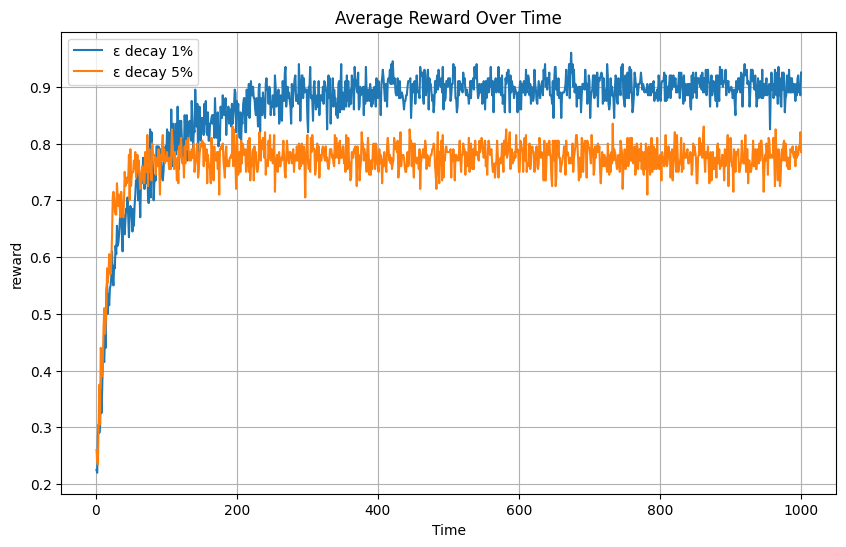

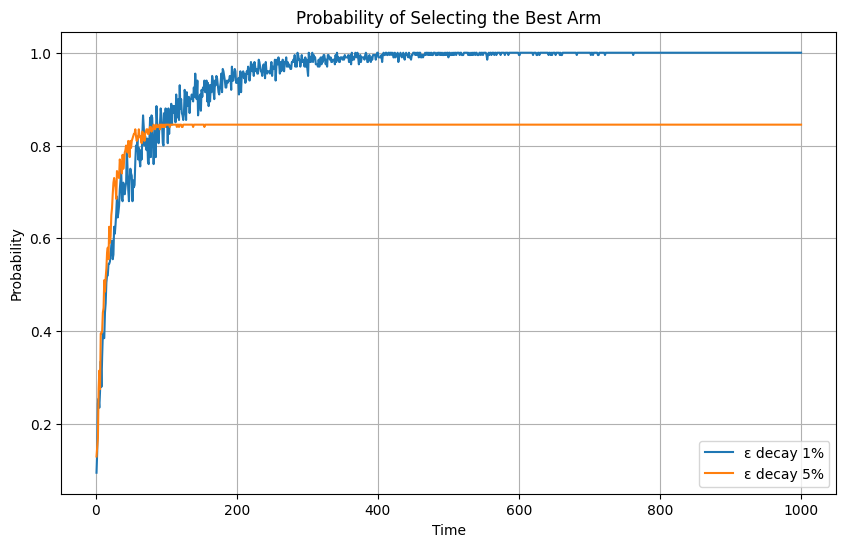

In [ ]:
# Show plots
plot_metric(df_decay, "reward", "Average Reward Over Time")
plot_best_arm_prob(df_decay, best_arm)

# 실험 목적
**Q. $\epsilon$ 값을 천천히 줄이는 것과 빠르게 줄이는 것 중 어느 쪽이 더 좋은 성능을 낼까?**

초기 $\epsilon= 0.5$에서 시작하여
- 1%씩 감소($\epsilon \;  decay \;1%$)
- 5%씩 감소($\epsilon \;  decay \;5%$)

# 평균 리워드 그래프
- 얼마나 효율적으로 좋은 행동을 선택했는지 보여줌
- 높을수록 좋음 : 보상을 많이 받았다는 뜻

## 5% 감소
- 초반에 $\epsilon$을 줄여서, 최적행동을 빨리 고정함 -> 초반 높은 보상을 얻음

 -> 빠르게 탐험을 줄이고 좋은 행동에 집중한 결과라고 볼 수 있지 않을까

## 1% 감소
- 탐험을 오래 유지해서 초반에 보상이 낮지만 후반부로 갈수록 안정적인 보상을 유지함

 -> 탐험을 좀 더 많이 길게 가져 다양한 행동을 시도한 것으로 볼 수 있음

# 최적 행동 선택 확률
- 얼마나 정확하게 최적 arm을 선택했는지를 나타냄
- 1에 가까울 수록 최적 arm을 잘 고른것

## 5% 감소
-  ε이 빨리 줄어들어 초기에는 빠르게 최적 arm에 수렴
- 빠르게 최적의 행동을 선택하는 확률이 올라가고 정착함

## 1% 감소
- ε이 천천히 줄어 탐험이 많아 초기에는 확률 낮지만, 후반엔 안정적
- 더 천천히 올라가지만, 전반적으로 더 안정적인 선택을 함


➡️ 빠르게 $\epsilon$를 줄이면 좋은 행동을 빨리 선택하지만, 실험 기회를 잃을 수도 있음

➡️ 느리게 줄이면 시간은 걸려도 더 정확한 판단을 할 수 있음

✅ 결국, ε 감소 속도는 문제 상황에 따라 조정되어야 하지 않을까...?



# 실험 목적
## What
- ε-greedy 알고리즘에서 보상 확률이 비슷한 경우와 확연히 다른 경우
→ 학습 성능(보상과 최적 행동 선택)에 어떤 차이가 나타나는지 확인

## why
- 현실에서는 행동 선택지(arms)의 보상이:

어떤 경우는 뻔하게 차이 남 (예: 광고 A는 10% 클릭률, B는 90%)

어떤 경우는 거의 비슷함 (예: [0.45, 0.47, 0.50, 0.49, 0.51])

이런 상황에서 ε-greedy 전략은 탐험을 얼마나 하느냐에 따라 성능이 크게 달라질 수 있기 때문에

탐험이 얼마나 잘 작동하는지 상황에 따라 비교하려는 것.



# 구성

- Arms 보상 확률
  - [0.1, 0.1, 0.1, 0.1, 0.9]
  - [0.45, 0.47, 0.50, 0.49, 0.51]

- ε 설정: initial=0.5, decay=0.01 (천천히 감소)

- 실험 횟수	200회 반복, 각 1000 step



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random


In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

In [ ]:
# Bernoulli Arm class
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    def draw(self):
        return 1.0 if random.random() < self.p else 0.0

In [ ]:
# EpsilonGreedy with decay
class EpsilonGreedyDecay():
    def __init__(self, initial_epsilon, decay_rate):
        self.initial_epsilon = initial_epsilon
        self.decay_rate = decay_rate
    def initialize(self, n_arms):
        self.t = 0
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
        self.epsilon = self.initial_epsilon
    def select_arm(self):
        self.t += 1
        self.epsilon = self.initial_epsilon * ((1 - self.decay_rate) ** self.t)
        if random.random() > self.epsilon:
            return self.values.index(max(self.values))
        return random.randrange(len(self.values))
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward


In [ ]:
# Test algorithm
def test_algorithm(algo, arms, num_sims, horizon, label):
    result = {"experiment": [], "sim": [], "time": [], "arm": [], "reward": [], "cum_reward": []}
    for sim in range(num_sims):
        algo.initialize(len(arms))
        total = 0.0
        for t in range(1, horizon + 1):
            arm = algo.select_arm()
            reward = arms[arm].draw()
            algo.update(arm, reward)
            total += reward
            result["experiment"].append(label)
            result["sim"].append(sim)
            result["time"].append(t)
            result["arm"].append(arm)
            result["reward"].append(reward)
            result["cum_reward"].append(total)
    return pd.DataFrame(result)

In [ ]:
# Plot functions
def plot_metric(df, metric, title):
    plt.figure(figsize=(10, 6))
    for label in df["experiment"].unique():
        subset = df[df["experiment"] == label]
        y = subset.groupby("time")[metric].mean()
        plt.plot(y.index, y.values, label=label)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def plot_best_arm_prob(df, best_arm):
    plt.figure(figsize=(10, 6))
    for label in df["experiment"].unique():
        subset = df[df["experiment"] == label]
        prob = subset.groupby("time")["arm"].apply(lambda x: sum(x == best_arm) / len(x))
        plt.plot(prob.index, prob.values, label=label)
    plt.title("Probability of Selecting the Best Arm")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# Run experiments for two different settings
num_sims, horizon = 200, 1000

In [ ]:
# Scenario 1: 큰 차이
random.seed(1)
means_easy = [0.1, 0.1, 0.1, 0.1, 0.9]
random.shuffle(means_easy)
arms_easy = [BernoulliArm(p) for p in means_easy]
best_arm_easy = means_easy.index(max(means_easy))
df_easy = test_algorithm(EpsilonGreedyDecay(0.5, 0.01), arms_easy, num_sims, horizon, "확률 차이가 큰 경우")

In [ ]:
# Scenario 2: 비슷한 확률
means_hard = [0.45, 0.47, 0.50, 0.49, 0.51]
random.shuffle(means_hard)
arms_hard = [BernoulliArm(p) for p in means_hard]
best_arm_hard = means_hard.index(max(means_hard))
df_hard = test_algorithm(EpsilonGreedyDecay(0.5, 0.01), arms_hard, num_sims, horizon, "확률 차이가 작은 경우")

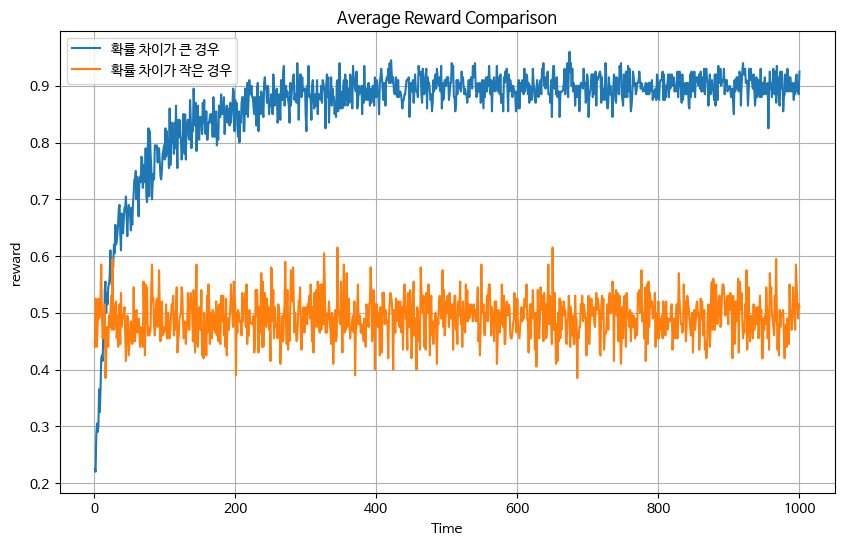

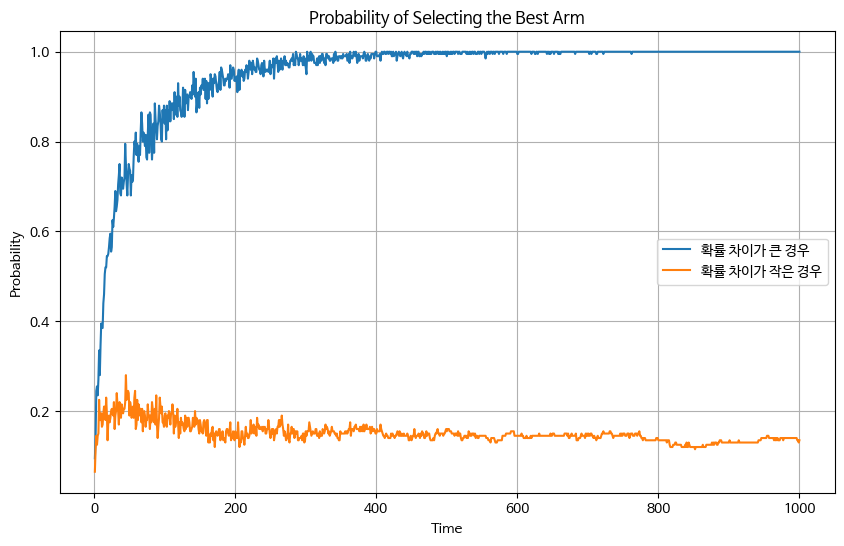

In [ ]:
# Combine and plot
combined_df = pd.concat([df_easy, df_hard])
plot_metric(combined_df, "reward", "Average Reward Comparison")
plot_best_arm_prob(combined_df, best_arm_easy)  # Note: the same function works, arm index is handled per experiment

# **평균 보상 그래프**
## 확률차이가 큰 경우
- 빠르게 높은 보상에 수렴
- 최적 arm을 쉽게 찾고 반복해서 선택함

## 확률이 비슷한 경우
- 보상이 계속 낮은 수준에 머무른다
- 최적 arm과 다른 arm의 차이가 작아서 탐험으로도 구분 어려움

# **최적 arm선택 확률 그래프**
## 확률차이가 큰경우
- 200~300 스텝부터 거의 100% 확률로 최적 arm 선택

 → 빠른 수렴

- 1000 스텝까지도 최적 arm 선택 확률 15% 이하

 → ε이 감소하면서 탐험이 줄었지만, 그 안에서 최적 arm을 발견하지 못함

# **결론**
- 보상 확률 간 차이가 클수록 ε-greedy는 성능이 훨씬 뛰어남

  - 탐험이 조금만 있어도 최적 arm을 빠르게 식별 가능
- 보상 확률이 비슷할수록 ε-greedy는 충분한 탐험 없이 실패 가능성 큼

  - ε 감소 속도가 고정되어 있으면, 학습 초기에 운에 따라 잘못된 arm에 수렴할 수 있음

# 궁금해서 해본 것들
## 확률 차이가 작은 경우에 그 단점이 만약 horizon이 커진다면 조금이라도 줄여줄 수 있을까?

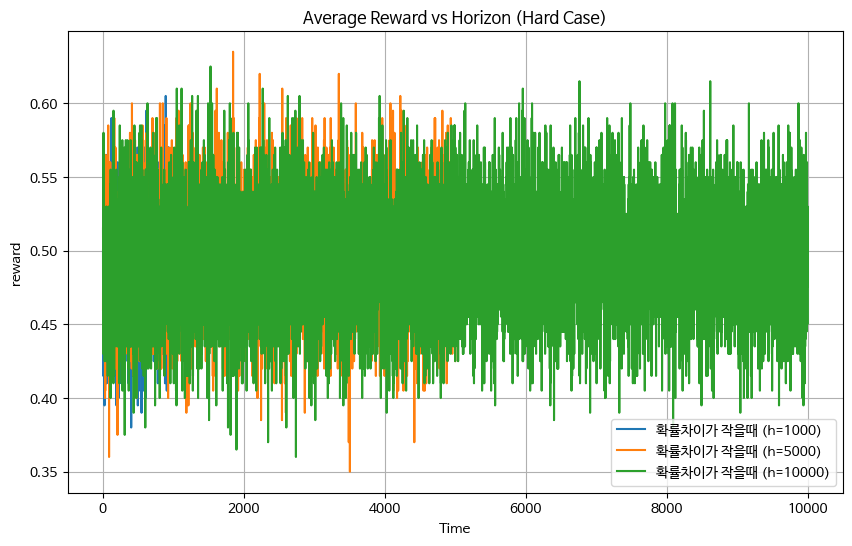

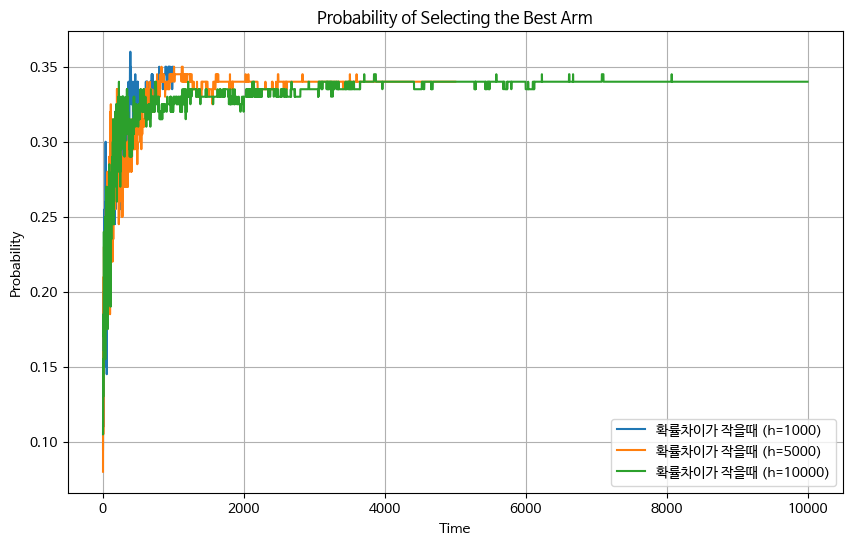

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Bernoulli Arm class
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    def draw(self):
        return 1.0 if random.random() < self.p else 0.0

# EpsilonGreedy with decay
class EpsilonGreedyDecay():
    def __init__(self, initial_epsilon, decay_rate):
        self.initial_epsilon = initial_epsilon
        self.decay_rate = decay_rate
    def initialize(self, n_arms):
        self.t = 0
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
        self.epsilon = self.initial_epsilon
    def select_arm(self):
        self.t += 1
        self.epsilon = self.initial_epsilon * ((1 - self.decay_rate) ** self.t)
        if random.random() > self.epsilon:
            return self.values.index(max(self.values))
        return random.randrange(len(self.values))
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward

# Test algorithm
def test_algorithm(algo, arms, num_sims, horizon, label):
    result = {"experiment": [], "sim": [], "time": [], "arm": [], "reward": [], "cum_reward": []}
    for sim in range(num_sims):
        algo.initialize(len(arms))
        total = 0.0
        for t in range(1, horizon + 1):
            arm = algo.select_arm()
            reward = arms[arm].draw()
            algo.update(arm, reward)
            total += reward
            result["experiment"].append(label)
            result["sim"].append(sim)
            result["time"].append(t)
            result["arm"].append(arm)
            result["reward"].append(reward)
            result["cum_reward"].append(total)
    return pd.DataFrame(result)

# Plot functions
def plot_metric(df, metric, title):
    plt.figure(figsize=(10, 6))
    for label in df["experiment"].unique():
        subset = df[df["experiment"] == label]
        y = subset.groupby("time")[metric].mean()
        plt.plot(y.index, y.values, label=label)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

def plot_best_arm_prob(df, best_arm):
    plt.figure(figsize=(10, 6))
    for label in df["experiment"].unique():
        subset = df[df["experiment"] == label]
        prob = subset.groupby("time")["arm"].apply(lambda x: sum(x == best_arm) / len(x))
        plt.plot(prob.index, prob.values, label=label)
    plt.title("Probability of Selecting the Best Arm")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid()
    plt.show()

# Compare hard cases with different horizons
random.seed(1)
means_hard = [0.45, 0.47, 0.50, 0.49, 0.51]
random.shuffle(means_hard)
arms_hard = [BernoulliArm(p) for p in means_hard]
best_arm_hard = means_hard.index(max(means_hard))

num_sims = 200
horizons = [1000, 5000, 10000]
df_list = []

for h in horizons:
    df = test_algorithm(EpsilonGreedyDecay(0.5, 0.01), arms_hard, num_sims, h, f"확률차이가 작을때 (h={h})")
    df_list.append(df)

combined_df = pd.concat(df_list)
plot_metric(combined_df, "reward", "Average Reward vs Horizon (Hard Case)")
plot_best_arm_prob(combined_df, best_arm_hard)

시간이 너무 길어서 그래프 변화가 안보여서 평균으로 바꿔서 그려봄

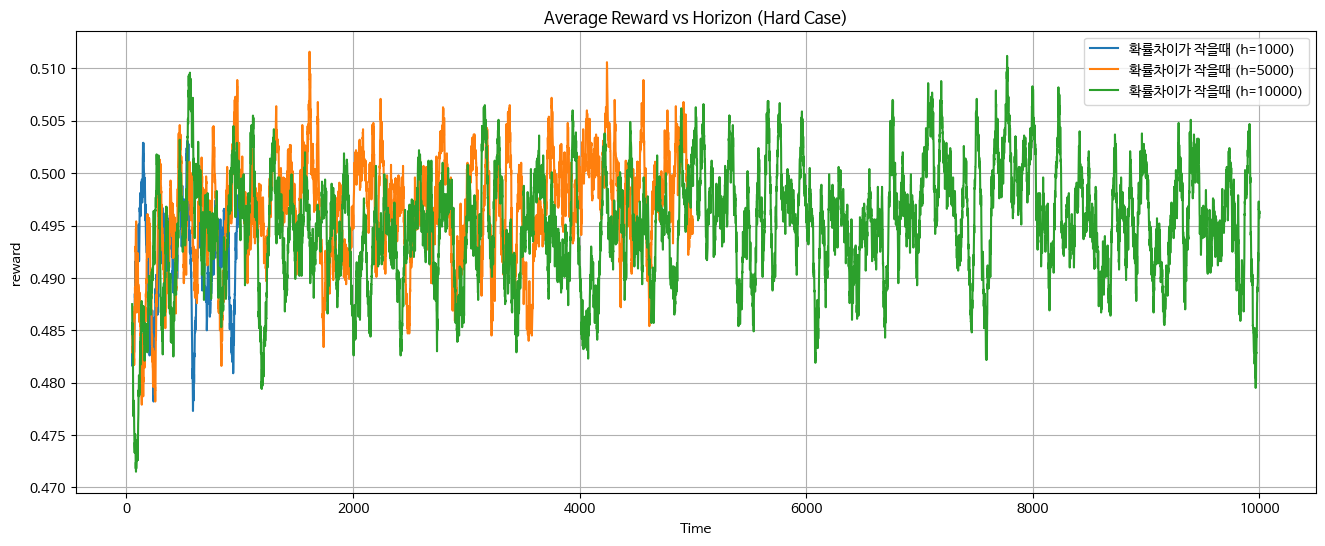

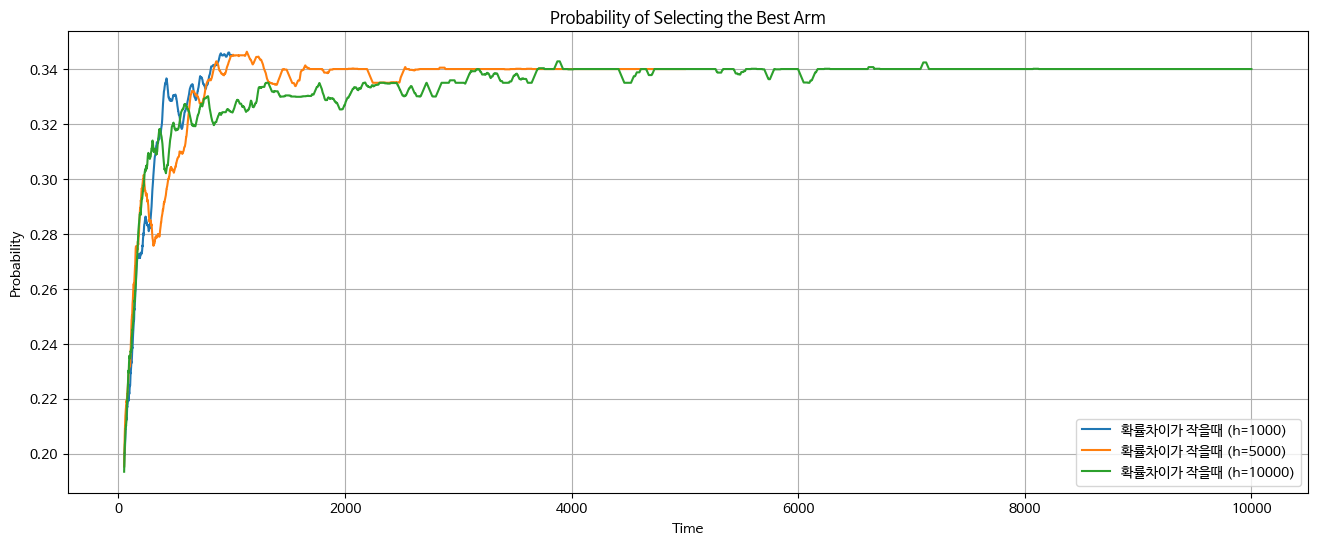

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Bernoulli Arm class
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    def draw(self):
        return 1.0 if random.random() < self.p else 0.0

# EpsilonGreedy with decay
class EpsilonGreedyDecay():
    def __init__(self, initial_epsilon, decay_rate):
        self.initial_epsilon = initial_epsilon
        self.decay_rate = decay_rate
    def initialize(self, n_arms):
        self.t = 0
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
        self.epsilon = self.initial_epsilon
    def select_arm(self):
        self.t += 1
        self.epsilon = self.initial_epsilon * ((1 - self.decay_rate) ** self.t)
        if random.random() > self.epsilon:
            return self.values.index(max(self.values))
        return random.randrange(len(self.values))
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward

# Test algorithm
def test_algorithm(algo, arms, num_sims, horizon, label):
    result = {"experiment": [], "sim": [], "time": [], "arm": [], "reward": [], "cum_reward": []}
    for sim in range(num_sims):
        algo.initialize(len(arms))
        total = 0.0
        for t in range(1, horizon + 1):
            arm = algo.select_arm()
            reward = arms[arm].draw()
            algo.update(arm, reward)
            total += reward
            result["experiment"].append(label)
            result["sim"].append(sim)
            result["time"].append(t)
            result["arm"].append(arm)
            result["reward"].append(reward)
            result["cum_reward"].append(total)
    return pd.DataFrame(result)

# Plot functions (updated for better visualization)
def plot_metric(df, metric, title):
    plt.figure(figsize=(16, 6))  # wider figure for long horizon
    for label in df["experiment"].unique():
        subset = df[df["experiment"] == label]
        y = subset.groupby("time")[metric].mean().rolling(window=50).mean()  # smoothing with moving average
        plt.plot(y.index, y.values, label=label)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

def plot_best_arm_prob(df, best_arm):
    plt.figure(figsize=(16, 6))
    for label in df["experiment"].unique():
        subset = df[df["experiment"] == label]
        prob = subset.groupby("time")["arm"].apply(lambda x: sum(x == best_arm) / len(x)).rolling(window=50).mean()
        plt.plot(prob.index, prob.values, label=label)
    plt.title("Probability of Selecting the Best Arm")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid()
    plt.show()

# Compare hard cases with different horizons
random.seed(1)
means_hard = [0.45, 0.47, 0.50, 0.49, 0.51]
random.shuffle(means_hard)
arms_hard = [BernoulliArm(p) for p in means_hard]
best_arm_hard = means_hard.index(max(means_hard))

num_sims = 200
horizons = [1000, 5000, 10000]
df_list = []

for h in horizons:
    df = test_algorithm(EpsilonGreedyDecay(0.5, 0.01), arms_hard, num_sims, h, f"확률차이가 작을때 (h={h})")
    df_list.append(df)

combined_df = pd.concat(df_list)
plot_metric(combined_df, "reward", "Average Reward vs Horizon (Hard Case)")
plot_best_arm_prob(combined_df, best_arm_hard)

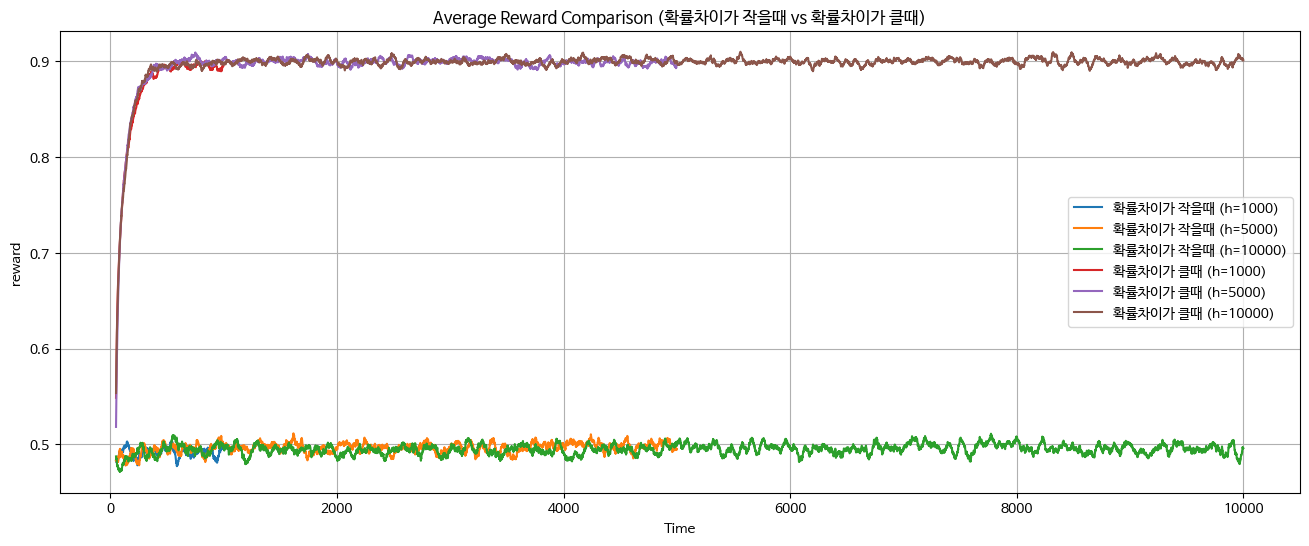

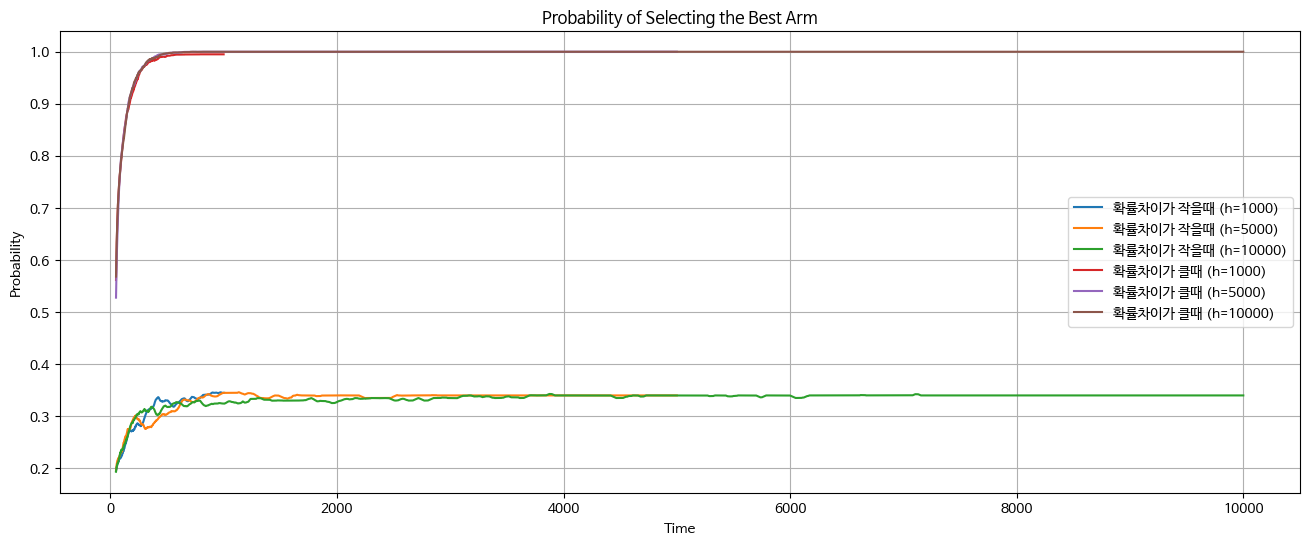

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Bernoulli Arm class
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    def draw(self):
        return 1.0 if random.random() < self.p else 0.0

# EpsilonGreedy with decay
class EpsilonGreedyDecay():
    def __init__(self, initial_epsilon, decay_rate):
        self.initial_epsilon = initial_epsilon
        self.decay_rate = decay_rate
    def initialize(self, n_arms):
        self.t = 0
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
        self.epsilon = self.initial_epsilon
    def select_arm(self):
        self.t += 1
        self.epsilon = self.initial_epsilon * ((1 - self.decay_rate) ** self.t)
        if random.random() > self.epsilon:
            return self.values.index(max(self.values))
        return random.randrange(len(self.values))
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward

# Test algorithm
def test_algorithm(algo, arms, num_sims, horizon, label):
    result = {"experiment": [], "sim": [], "time": [], "arm": [], "reward": [], "cum_reward": []}
    for sim in range(num_sims):
        algo.initialize(len(arms))
        total = 0.0
        for t in range(1, horizon + 1):
            arm = algo.select_arm()
            reward = arms[arm].draw()
            algo.update(arm, reward)
            total += reward
            result["experiment"].append(label)
            result["sim"].append(sim)
            result["time"].append(t)
            result["arm"].append(arm)
            result["reward"].append(reward)
            result["cum_reward"].append(total)
    return pd.DataFrame(result)

# Plot functions (updated for better visualization)
def plot_metric(df, metric, title):
    plt.figure(figsize=(16, 6))
    for label in df["experiment"].unique():
        subset = df[df["experiment"] == label]
        y = subset.groupby("time")[metric].mean().rolling(window=50).mean()
        plt.plot(y.index, y.values, label=label)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

def plot_best_arm_prob(df, best_arm_dict):
    plt.figure(figsize=(16, 6))
    for label in df["experiment"].unique():
        subset = df[df["experiment"] == label]
        best_arm = best_arm_dict[label]
        prob = subset.groupby("time")["arm"].apply(lambda x: sum(x == best_arm) / len(x)).rolling(window=50).mean()
        plt.plot(prob.index, prob.values, label=label)
    plt.title("Probability of Selecting the Best Arm")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid()
    plt.show()

# Horizon 비교 실험: Hard Case + Easy Case
random.seed(1)

num_sims = 200
horizons = [1000, 5000, 10000]
df_list = []
best_arm_dict = {}

# Hard Case 실험
means_hard = [0.45, 0.47, 0.50, 0.49, 0.51]
random.shuffle(means_hard)
arms_hard = [BernoulliArm(p) for p in means_hard]
best_arm_hard = means_hard.index(max(means_hard))

for h in horizons:
    label = f"확률차이가 작을때 (h={h})"
    df = test_algorithm(EpsilonGreedyDecay(0.5, 0.01), arms_hard, num_sims, h, label)
    df_list.append(df)
    best_arm_dict[label] = best_arm_hard

# Easy Case 실험
means_easy = [0.1, 0.1, 0.1, 0.1, 0.9]
random.shuffle(means_easy)
arms_easy = [BernoulliArm(p) for p in means_easy]
best_arm_easy = means_easy.index(max(means_easy))

for h in horizons:
    label = f"확률차이가 클때 (h={h})"
    df = test_algorithm(EpsilonGreedyDecay(0.5, 0.01), arms_easy, num_sims, h, label)
    df_list.append(df)
    best_arm_dict[label] = best_arm_easy

# 통합 결과 시각화
combined_df = pd.concat(df_list)
plot_metric(combined_df, "reward", "Average Reward Comparison (확률차이가 작을때 vs 확률차이가 클때)")
plot_best_arm_prob(combined_df, best_arm_dict)

결론은 크게 바뀌진 않는다..?


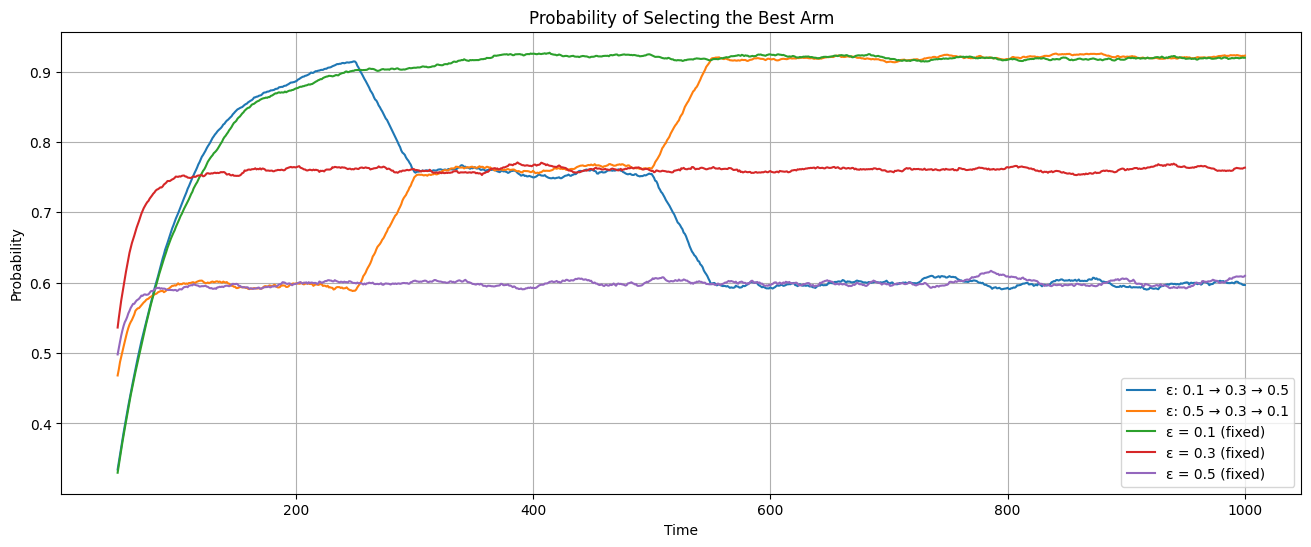

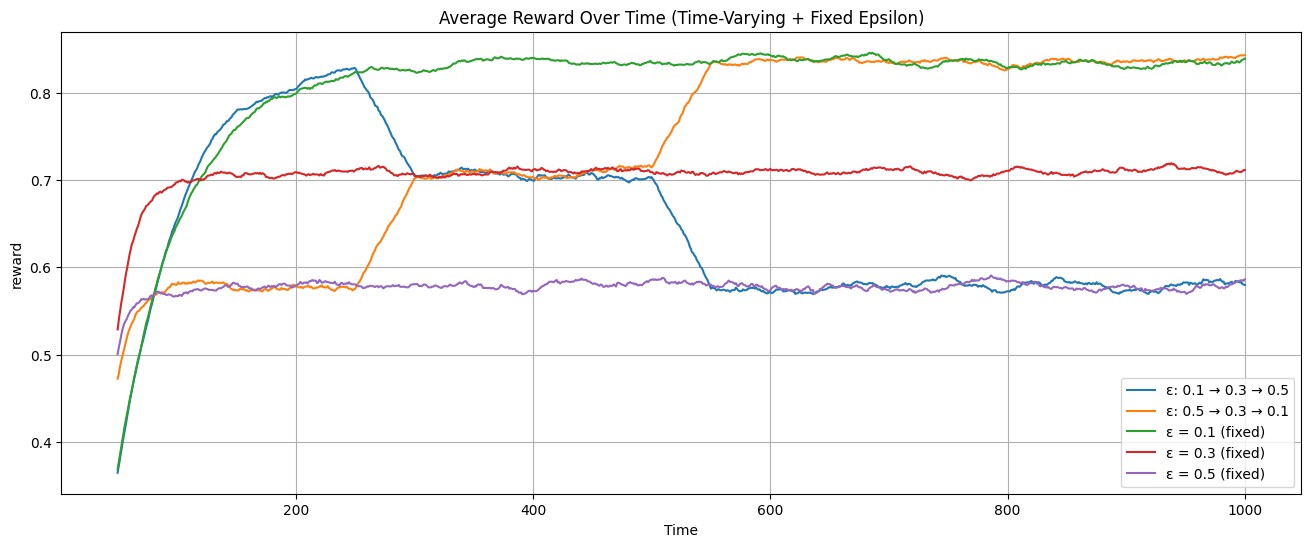

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Bernoulli Arm class
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    def draw(self):
        return 1.0 if random.random() < self.p else 0.0

# EpsilonGreedy with decay
class EpsilonGreedyDecay():
    def __init__(self, initial_epsilon, decay_rate):
        self.initial_epsilon = initial_epsilon
        self.decay_rate = decay_rate
    def initialize(self, n_arms):
        self.t = 0
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
        self.epsilon = self.initial_epsilon
    def select_arm(self):
        self.t += 1
        self.epsilon = self.initial_epsilon * ((1 - self.decay_rate) ** self.t)
        if random.random() > self.epsilon:
            return self.values.index(max(self.values))
        return random.randrange(len(self.values))
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward

# EpsilonGreedy fixed
class EpsilonGreedy():
    def __init__(self, epsilon):
        self.epsilon = epsilon
    def initialize(self, n_arms):
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
    def select_arm(self):
        if random.random() > self.epsilon:
            return self.values.index(max(self.values))
        return random.randrange(len(self.values))
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward

# Time-Varying Epsilon
class EpsilonGreedySchedule():
    def __init__(self, schedule):
        self.schedule = schedule
        self.t = 0
        self.counts = []
        self.values = []
        self.epsilon = list(schedule.values())[0]
    def initialize(self, n_arms):
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0.0 for _ in range(n_arms)]
        self.t = 0
    def select_arm(self):
        self.t += 1
        for bound in sorted(self.schedule.keys()):
            if self.t <= bound:
                self.epsilon = self.schedule[bound]
                break
        if random.random() > self.epsilon:
            return self.values.index(max(self.values))
        else:
            return random.randrange(len(self.values))
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / float(n)) * value + (1 / float(n)) * reward

# Test algorithm
def test_algorithm(algo, arms, num_sims, horizon, label):
    result = {"experiment": [], "sim": [], "time": [], "arm": [], "reward": [], "cum_reward": []}
    for sim in range(num_sims):
        algo.initialize(len(arms))
        total = 0.0
        for t in range(1, horizon + 1):
            arm = algo.select_arm()
            reward = arms[arm].draw()
            algo.update(arm, reward)
            total += reward
            result["experiment"].append(label)
            result["sim"].append(sim)
            result["time"].append(t)
            result["arm"].append(arm)
            result["reward"].append(reward)
            result["cum_reward"].append(total)
    return pd.DataFrame(result)

# Plot functions
def plot_metric(df, metric, title):
    plt.figure(figsize=(16, 6))
    for label in df["experiment"].unique():
        subset = df[df["experiment"] == label]
        y = subset.groupby("time")[metric].mean().rolling(window=50).mean()
        plt.plot(y.index, y.values, label=label)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

def plot_best_arm_prob(df, best_arm):
    plt.figure(figsize=(16, 6))
    for label in df["experiment"].unique():
        subset = df[df["experiment"] == label]
        prob = subset.groupby("time")["arm"].apply(lambda x: sum(x == best_arm) / len(x)).rolling(window=50).mean()
        plt.plot(prob.index, prob.values, label=label)
    plt.title("Probability of Selecting the Best Arm")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid()
    plt.show()

# 실험 설정
random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
random.shuffle(means)
arms = [BernoulliArm(p) for p in means]
best_arm = means.index(max(means))
num_sims = 200
horizon = 1000

# Time-Varying Epsilon 실험
sched1 = EpsilonGreedySchedule({250: 0.1, 500: 0.3, 1000: 0.5})
sched2 = EpsilonGreedySchedule({250: 0.5, 500: 0.3, 1000: 0.1})
df_sched1 = test_algorithm(sched1, arms, num_sims, horizon, "ε: 0.1 → 0.3 → 0.5")
df_sched2 = test_algorithm(sched2, arms, num_sims, horizon, "ε: 0.5 → 0.3 → 0.1")

# 고정된 Epsilon 실험
df_fixed1 = test_algorithm(EpsilonGreedy(0.1), arms, num_sims, horizon, "ε = 0.1 (fixed)")
df_fixed2 = test_algorithm(EpsilonGreedy(0.3), arms, num_sims, horizon, "ε = 0.3 (fixed)")
df_fixed3 = test_algorithm(EpsilonGreedy(0.5), arms, num_sims, horizon, "ε = 0.5 (fixed)")

# 결과 통합 및 시각화
df_all = pd.concat([df_sched1, df_sched2, df_fixed1, df_fixed2, df_fixed3])
plot_best_arm_prob(df_all, best_arm)
plot_metric(df_all, "reward", "Average Reward Over Time (Time-Varying + Fixed Epsilon)")